In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import snapatac2 as snap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm

def load_network(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

def extract_edge_scores(network):
    edges_with_scores = []
    for peak, gene, edge_data in network.edge_index_map().values():
        cor_score = getattr(edge_data, "cor_score", None)
        if cor_score is not None and not np.isnan(cor_score):
            peak_data = network[peak]
            gene_data = network[gene]
            edges_with_scores.append((peak_data.id, gene_data.id, cor_score))
    return edges_with_scores

def plot_qq_plot(cor_scores_array):
    fig = sm.qqplot(cor_scores_array, line='45', fit=True)
    plt.title('Q-Q Plot of Correlation Scores')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.xlim(-7, 7)
    plt.setp(plt.gca().lines, markersize=2)
    plt.show()

def plot_density_plot(cor_scores):
    sns.set(style="whitegrid")
    sns.histplot(cor_scores, kde=True, bins=30)
    plt.title('Density Plot of Edge Correlation Scores')
    plt.xlabel('Correlation Score')
    plt.ylabel('Density')
    plt.show()

In [3]:
expr = sc.read_h5ad("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/SEACells/model300/RNA_SCT_average.h5ad")
damage = sc.read_h5ad("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/SEACells/model300/DamagePeak_FixedLen_DS_040824.h5ad", backed = None)

In [4]:
#get the variable genes
sc.experimental.pp.recipe_pearson_residuals(expr, n_top_genes = 4000)
variable_gene = expr.var.index[expr.var.highly_variable == True].to_list()
variable_gene[1:5]

/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:151: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/scanpy/experimental/pp/_normalization.py:52: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(


['C1orf112', 'CFH', 'GCLC', 'NIPAL3']

In [5]:
highly_expressed_genes = expr.var[expr.var["pct_dropout_by_counts"] < 5].index.to_list()
highly_expressed_genes[1:5]
print(len(highly_expressed_genes))

13833


In [6]:
variable_genes = expr.var[expr.var["residual_variances"] > 0.02].index.to_list()
len(variable_genes)

2627

In [7]:
overlap = set(highly_expressed_genes).intersection(set(variable_gene))
len(overlap)

3982

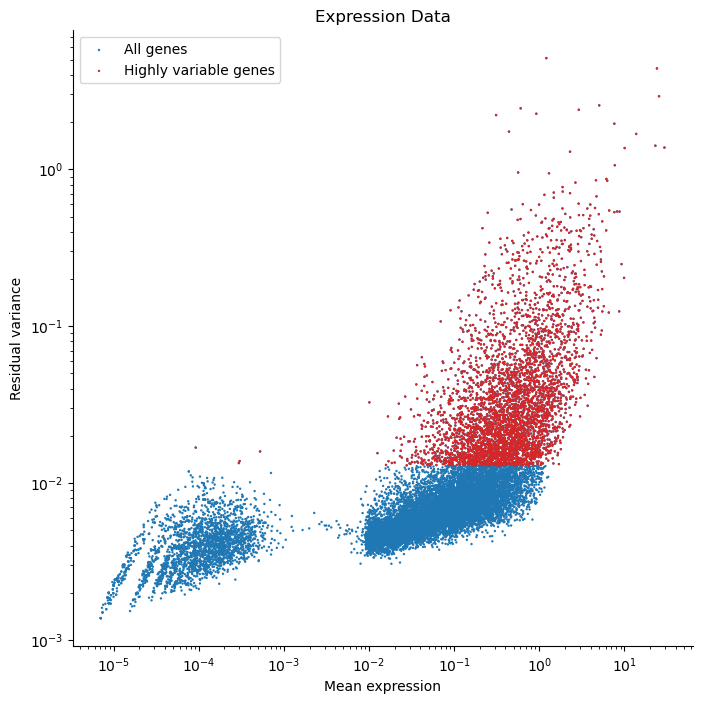

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

hvgs = expr.var["highly_variable"]

# Plot all genes
ax.scatter(
    expr.var["mean_counts"], expr.var["residual_variances"], s=3, edgecolor="none", label="All genes"
)
# Highlight highly variable genes
ax.scatter(
    expr.var["mean_counts"][hvgs],
    expr.var["residual_variances"][hvgs],
    c="tab:red",
    label="Highly variable genes",
    s=3,
    edgecolor="none",
)

ax.set_xscale("log")
ax.set_xlabel("Mean expression")
ax.set_yscale("log")
ax.set_ylabel("Residual variance")
ax.set_title(expr.uns.get("name", "Expression Data"))  # Fallback title if "name" is not set

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

plt.legend()
plt.show()

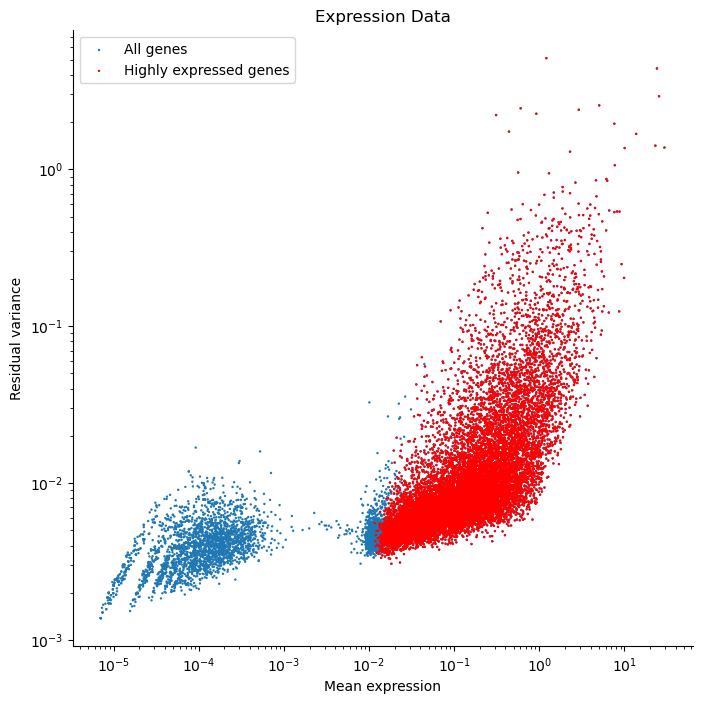

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Assuming highly_expressed_genes is a list of gene names that match the index of expr.var
highly_expressed_mask = highly_expressed_genes

# Plot all genes
ax.scatter(
    expr.var["mean_counts"], expr.var["residual_variances"], s=3, edgecolor="none", label="All genes"
)

# Highlight highly expressed genes in red
ax.scatter(
    expr.var["mean_counts"][highly_expressed_mask],
    expr.var["residual_variances"][highly_expressed_mask],
    c="red",  # Change color to red
    label="Highly expressed genes",  # Update label
    s=3,
    edgecolor="none",
)

ax.set_xscale("log")
ax.set_xlabel("Mean expression")
ax.set_yscale("log")
ax.set_ylabel("Residual variance")
ax.set_title(expr.uns.get("name", "Expression Data"))  # Fallback title if "name" is not set

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

plt.legend()
plt.show()


In [10]:
expr

AnnData object with n_obs × n_vars = 213 × 19564
    obs: 'RNA_anno', 'RNA_anno_purity', 'Treatment', 'Treatment_purity', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'RNA_anno_colors', 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [11]:
damage

AnnData object with n_obs × n_vars = 213 × 102705
    obs: 'RNA_anno', 'RNA_anno_purity', 'Treatment', 'Treatment_purity', 'n_InPeak_by_read', 'total_read'
    var: 'n_cells_by_read', 'mean_read', 'pct_dropout_by_read', 'total_read'
    uns: 'Treatment_colors'
    layers: 'raw'

In [12]:
expr_sorted = expr[damage.obs_names, ].copy()
expr_sorted

AnnData object with n_obs × n_vars = 213 × 19564
    obs: 'RNA_anno', 'RNA_anno_purity', 'Treatment', 'Treatment_purity', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'RNA_anno_colors', 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [13]:
#to show that matrices were indeed different 
diff = expr_sorted.X - expr.X
diff.nnz

3200756

In [14]:
regions = damage.var.index.to_list()
network = snap.tl.init_network_from_annotation(regions, 
                                               anno_file = snap.genome.GRCh38, 
                                               upstream=500000, 
                                               downstream=500000, 
                                               id_type='gene_name', 
                                               coding_gene_only=True)
network.num_edges()

496623

In [15]:
len(regions)

102705

In [16]:
snap.tl.add_cor_scores(network, 
                       gene_mat=expr_sorted, 
                       peak_mat=damage, 
                       select=variable_gene, 
                       overwrite=True)

100%|██████████| 3888/3888 [00:05<00:00, 747.50it/s]


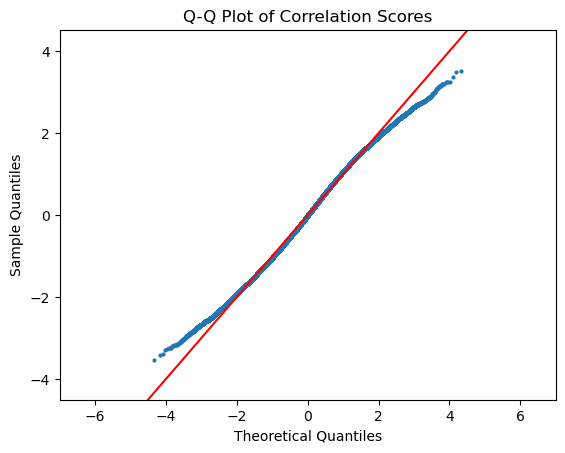

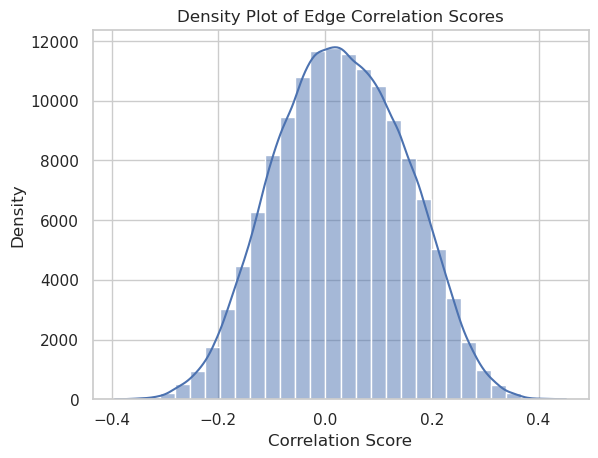

In [17]:
edges_scores = extract_edge_scores(network)
cor_scores = [edge[2] for edge in edges_scores]
cor_scores_array = np.array(cor_scores)
cor_scores_array = cor_scores_array[np.isfinite(cor_scores_array)]

plot_qq_plot(cor_scores_array)
plot_density_plot(cor_scores)

In [18]:
df = pd.DataFrame(extract_edge_scores(network), columns=['peak', 'gene', 'cor_score'])
df.sort_values(by = "cor_score", ascending = False).head(20)

,peak,gene,cor_score
102766,chr11:65502301-65503502,MUS81,0.451441
4962,chr11:65502301-65503502,CDCA5,0.448546
14686,chr12:12836036-12837237,EMP1,0.433565
124698,chr22:40804795-40805996,MRTFA,0.420671
46225,chr5:14370483-14371684,DNAH5,0.420277
46345,chr5:14164442-14165643,DNAH5,0.419944
62023,chr15:56123991-56125192,NEDD4,0.419228
94218,chr5:14905476-14906677,TRIO,0.414650
29013,chr4:122900288-122901489,NUDT6,0.414136
124704,chr22:40487010-40488211,MRTFA,0.413841


In [19]:
df.sort_values(by = "cor_score", ascending = True).head(20)

,peak,gene,cor_score
15143,chr1:196685576-196686777,KCNT2,-0.393621
114409,chr5:10385338-10386539,CMBL,-0.381453
36025,chr22:40612110-40613311,TNRC6B,-0.377840
94557,chr13:77063535-77064736,MYCBP2,-0.364601
138307,chr1:52813988-52815189,TUT4,-0.361403
76989,chr4:139607140-139608341,ELF2,-0.360954
77771,chr1:186873513-186874714,PLA2G4A,-0.359199
13997,chr5:22043506-22044707,CDH12,-0.358317
51915,chr6:99545402-99546603,PNISR,-0.354240
134940,chr2:211650566-211651767,ERBB4,-0.354036


In [20]:
network_bg = snap.tl.init_network_from_annotation(regions, 
                                                  snap.genome.GRCh38, 
                                                  upstream=500000, 
                                                  downstream=500000, 
                                                  id_type='gene_name', 
                                                  coding_gene_only=True)

In [21]:
# some code to shuffle damage matrix
background2 = damage.copy()
random_peaks = np.random.permutation(background2.var.index)
random_cells = np.random.permutation(background2.obs.index)

#background = background[random_cells, random_peaks]
background2 = background2[random_cells, :]
#background2 = background2[:, random_peaks]


background2.var = damage.var
background2.obs = damage.obs

In [22]:
diff = damage.X - background2.X
diff.nnz

13330884

In [23]:
snap.tl.add_cor_scores(network_bg, 
                           gene_mat=expr_sorted, 
                           peak_mat=background2, 
                           select=variable_gene, 
                           overwrite=True)

100%|██████████| 3888/3888 [00:05<00:00, 730.00it/s]


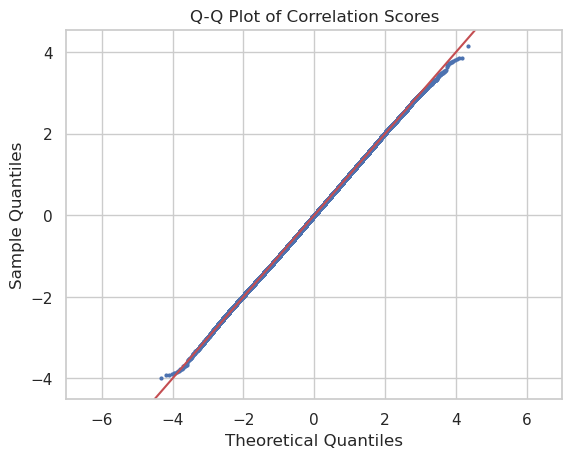

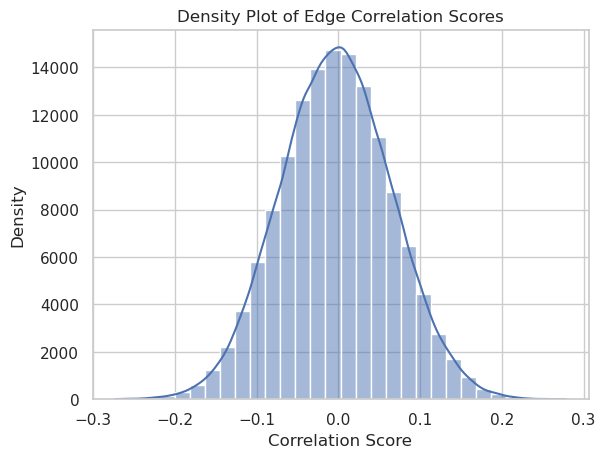

In [24]:
edges_scores = extract_edge_scores(network_bg)
cor_scores = [edge[2] for edge in edges_scores]
cor_scores_array = np.array(cor_scores)
cor_scores_array = cor_scores_array[np.isfinite(cor_scores_array)]

plot_qq_plot(cor_scores_array)
plot_density_plot(cor_scores)

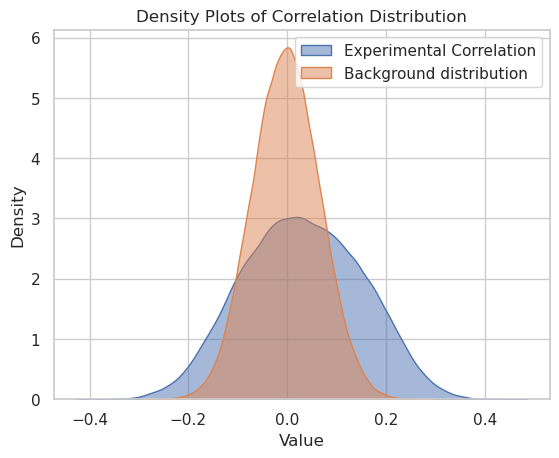

In [25]:
df = pd.DataFrame(extract_edge_scores(network), columns=['peak', 'gene', 'cor_score'])
df_bg = pd.DataFrame(extract_edge_scores(network_bg), columns=['peak', 'gene', 'cor_score'])

sorted_df = np.sort(df['cor_score'].dropna())
sorted_df_bg = np.sort(df_bg['cor_score'].dropna())
# Plot the density plots
sns.kdeplot(sorted_df, label='Experimental Correlation', fill=True, common_norm=False, alpha=0.5)
sns.kdeplot(sorted_df_bg, label='Background distribution', fill=True, common_norm=False, alpha=0.5)

# Adding labels
plt.title('Density Plots of Correlation Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [26]:
from scipy.stats import norm, gaussian_kde
from statsmodels.stats.multitest import multipletests

# Estimate the parameters of Gaussian from background data
bg_mean, bg_std = norm.fit(sorted_df_bg)

# Calculate p-values for the experimental data
p_values = 2 * (1 - norm.cdf(abs(sorted_df - bg_mean), loc=0, scale=bg_std))

# Calculate FDR using Benjamini-Hochberg
_, fdr_bh, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

In [30]:
df_p = pd.DataFrame({"scores": sorted_df, "fdr": fdr_bh})
df_p

,scores,fdr
0,-0.393621,0.000041
1,-0.381453,0.000082
2,-0.377840,0.000088
3,-0.364601,0.000137
4,-0.361403,0.000143
...,...,...
138309,0.420277,0.000010
138310,0.420671,0.000010
138311,0.433565,0.000006
138312,0.448546,0.000002


In [28]:
filtered_df = df[df['fdr'] <= 0.05]
filtered_df = filtered_df.sort_values(by='scores')

negative_cutoff = filtered_df[filtered_df['scores'] < 0]['scores'].max()

positive_cutoff = filtered_df[filtered_df['scores'] > 0]['scores'].min()

print("Negative score cutoff for FDR <= 0.05:", negative_cutoff)
print("Positive score cutoff for FDR <= 0.05:", positive_cutoff)

Negative score cutoff for FDR <= 0.05: -0.1838804929545745
Positive score cutoff for FDR <= 0.05: 0.17811261698611813


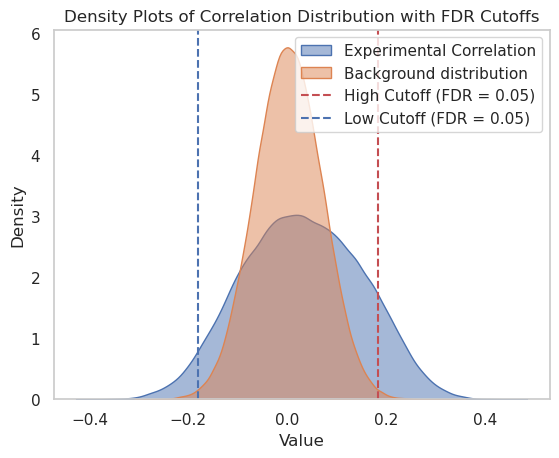

In [29]:
sns.kdeplot(sorted_df, label='Experimental Correlation', fill=True, common_norm=False, alpha=0.5)
sns.kdeplot(sorted_df_bg, label='Background distribution', fill=True, common_norm=False, alpha=0.5)

# Add vertical lines for the FDR cutoffs
plt.axvline(x=positive_cutoff, color='r', linestyle='--', label='High Cutoff (FDR = 0.05)')
plt.axvline(x=negative_cutoff, color='b', linestyle='--', label='Low Cutoff (FDR = 0.05)')

# Adding labels and title
plt.title('Density Plots of Correlation Distribution with FDR Cutoffs')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(False)
plt.legend()

# Show the plot
plt.show()


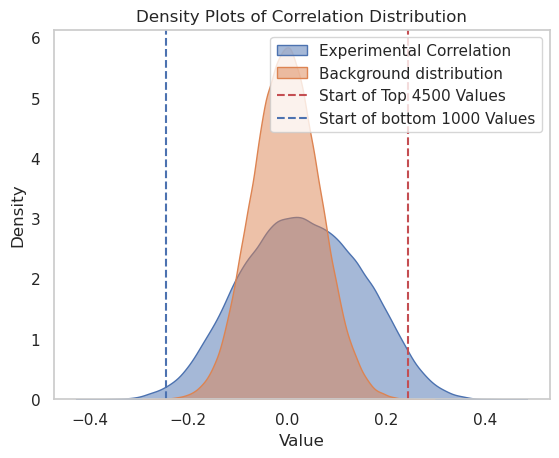

In [33]:
df = pd.DataFrame(extract_edge_scores(network), columns=['peak', 'gene', 'cor_score'])
df_bg = pd.DataFrame(extract_edge_scores(network_bg), columns=['peak', 'gene', 'cor_score'])

# Sort and drop NaN values
sorted_df = np.sort(df['cor_score'].dropna())
sorted_df_bg = np.sort(df_bg['cor_score'].dropna())

# Plot the density plots for the full distributions
sns.kdeplot(sorted_df, label='Experimental Correlation', fill=True, common_norm=False, alpha=0.5)
sns.kdeplot(sorted_df_bg, label='Background distribution', fill=True, common_norm=False, alpha=0.5)

if len(sorted_df) > 3000:
    cutoff_value_high = sorted_df[-4500]  

    # Add a vertical line to indicate the start of the top 1000 values
    plt.axvline(x=cutoff_value_high, color='r', linestyle='--', label='Start of Top 4500 Values')
    
    cutoff_value_low = sorted_df[1000]  # The value that starts the top 1000 values
    plt.axvline(x=cutoff_value_low, color='b', linestyle='--', label='Start of bottom 1000 Values')


# Adding labels and title
plt.title('Density Plots of Correlation Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(False)

# Show legend
plt.legend()

# Save the plot
#plt.savefig("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/Joint/Plots/LinkageVsBackground.png", bbox_inches='tight', dpi=500)
# Display the plot
plt.show()

In [31]:
df.to_csv("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/Joint/DS/PeakGeneLinkFix_041024_SEACell300.csv")
df_bg.to_csv("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/Joint/DS/PeakGeneLinkFix_041024_SEACell300_bg.csv")

In [32]:
def peaks_to_bed(peaks):
    return [peak.split(':')[0] + "\t" + peak.split(':')[1].replace('-', '\t') for peak in peaks]

In [33]:
df_fdr_positive = df[df["cor_score"] > positive_cutoff]
df_fdr_positive.shape

(14911, 3)

In [34]:
df_fdr_positive_unique_peaks = df_fdr_positive.drop_duplicates(subset='peak', keep='first')
len(df_fdr_positive_unique_peaks)

11814

In [35]:
df_fdr_positive_unique_peaks[0:5]

,peak,gene,cor_score
29,chr15:89671892-89673093,TICRR,0.202038
49,chr9:18365946-18367147,ADAMTSL1,0.210508
109,chr9:18152123-18153324,ADAMTSL1,0.192582
129,chr9:19264197-19265398,ADAMTSL1,0.201069
194,chr9:19273638-19274839,ADAMTSL1,0.201091


In [36]:
top_peaks_bed = peaks_to_bed(df_fdr_positive_unique_peaks["peak"].to_list())

file_path = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/Joint/DS/TopLinkFixPeaksTopFDR_042324.bed"

# Write the list to a file
with open(file_path, 'w') as f:
    for line in top_peaks_bed:
        f.write(line + "\n")

In [37]:
df_fdr_negative = df[df["cor_score"] < negative_cutoff]
df_fdr_negative.shape

(4938, 3)

In [38]:
df_fdr_negative_unique_peaks = df_fdr_negative.drop_duplicates(subset='peak', keep='first')
len(df_fdr_negative_unique_peaks)

4362

In [39]:
df_fdr_negative_unique_peaks[0:5]

,peak,gene,cor_score
114,chr9:18371585-18372786,ADAMTSL1,-0.183226
382,chr4:90615944-90617145,CCSER1,-0.212380
391,chr4:89736294-89737495,CCSER1,-0.208873
410,chr5:41619636-41620837,PLCXD3,-0.237511
411,chr5:41799711-41800912,PLCXD3,-0.181786


In [40]:
bottom_peaks_bed = peaks_to_bed(df_fdr_negative_unique_peaks["peak"].to_list())

file_path = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/Joint/DS/TopLinkFixPeaksBottomFDR_042324.bed"

# Write the list to a file
with open(file_path, 'w') as f:
    for line in bottom_peaks_bed:
        f.write(line + "\n")

In [34]:
df_sorted = df.sort_values(by='cor_score', ascending=False)
df_unique_peaks = df_sorted.drop_duplicates(subset='peak', keep='first')

top_4500_unique_peaks = df_unique_peaks.head(4500)
top_4500_unique_peaks[0:10]

,peak,gene,cor_score
15798,chr11:65502301-65503502,MUS81,0.451441
49892,chr12:12836036-12837237,EMP1,0.433565
25956,chr22:40804795-40805996,MRTFA,0.420671
75304,chr5:14370483-14371684,DNAH5,0.420277
75391,chr5:14164442-14165643,DNAH5,0.419944
99093,chr15:56123991-56125192,NEDD4,0.419228
27160,chr5:14905476-14906677,TRIO,0.414650
11406,chr4:122900288-122901489,NUDT6,0.414136
25960,chr22:40487010-40488211,MRTFA,0.413841
128877,chr7:92706966-92708167,CDK6,0.408297


In [34]:
df_good = df.join(df_p)
df_good

,peak,gene,cor_score,scores,fdr
0,chr12:51568160-51569361,NR4A1,-0.145771,-0.393621,0.000041
1,chr12:52250787-52251988,NR4A1,-0.055740,-0.381453,0.000082
2,chr12:52179311-52180512,NR4A1,0.065735,-0.377840,0.000088
3,chr12:52235341-52236542,NR4A1,-0.072135,-0.364601,0.000137
4,chr12:51575418-51576619,NR4A1,-0.052603,-0.361403,0.000143
...,...,...,...,...,...
138309,chr1:52089884-52091085,TUT4,-0.165562,0.420277,0.000010
138310,chr1:52072832-52074033,TUT4,-0.162891,0.420671,0.000010
138311,chr1:52449822-52451023,TUT4,-0.136143,0.433565,0.000006
138312,chr1:52635814-52637015,TUT4,-0.005717,0.448546,0.000002


In [32]:
df.head()

,scores,fdr
0,-0.393621,0.000041
1,-0.381453,0.000082
2,-0.377840,0.000088
3,-0.364601,0.000137
4,-0.361403,0.000143


In [35]:
df_good.to_csv("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/Joint/DS/PeakGeneLinkFix_050924_SEACell300.csv")


In [4]:
def plot_peak_gene_linkage(scRNA_anndata, snATAC_anndata, gene_name, peak_name):
    """
    Plot the linkage between a specific peak's accessibility level and a gene's expression level.

    Parameters:
    - scRNA_anndata: An AnnData object containing scRNA-seq data.
    - snATAC_anndata: An AnnData object containing snATAC-seq data.
    - gene_name: The name of the gene of interest.
    - peak_name: The name of the peak of interest.
    """
    # Check if gene_name is in scRNA-seq data
    if gene_name not in scRNA_anndata.var_names:
        print(f"Gene {gene_name} not found in scRNA-seq dataset.")
        return
    
    # Check if peak_name is in snATAC-seq data
    if peak_name not in snATAC_anndata.var_names:
        print(f"Peak {peak_name} not found in snATAC-seq dataset.")
        return
    
    # Extract expression levels for the gene of interest
    gene_expression = scRNA_anndata[:, gene_name].X
    
    # Extract accessibility levels for the peak of interest
    peak_accessibility = snATAC_anndata[:, peak_name].X
    
    # Ensure data is in a compatible format (e.g., dense if it's sparse)
    if hasattr(gene_expression, "toarray"):
        gene_expression = gene_expression.toarray().flatten()
    if hasattr(peak_accessibility, "toarray"):
        peak_accessibility = peak_accessibility.toarray().flatten()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(peak_accessibility, gene_expression, alpha=0.5)
    plt.xlabel(f"Accessibility of {peak_name}")
    plt.ylabel(f"Expression of {gene_name}")
    plt.title(f"Linkage between {peak_name} and {gene_name}")
    plt.show()

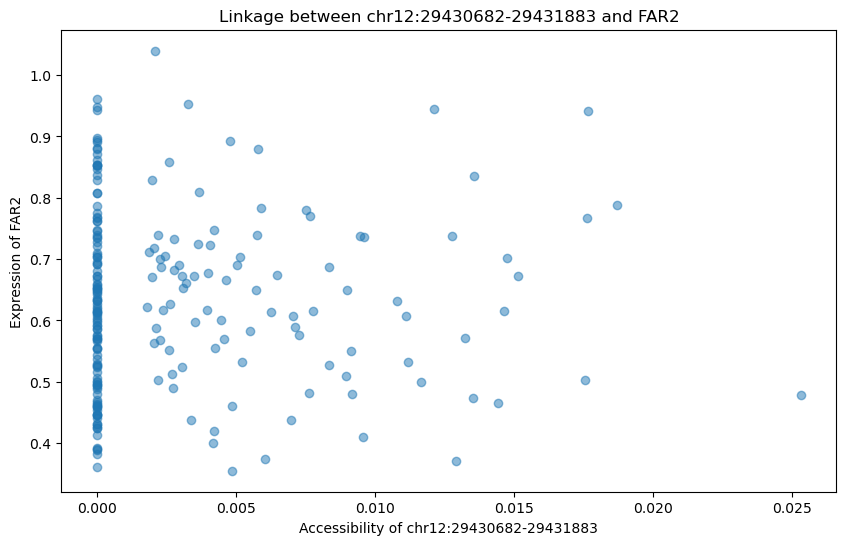

In [20]:
plot_peak_gene_linkage(expr, damage, "FAR2", "chr12:29430682-29431883")

In [12]:
expr

AnnData object with n_obs × n_vars = 213 × 19564
    obs: 'RNA_anno', 'RNA_anno_purity', 'Treatment', 'Treatment_purity', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'RNA_anno_colors'
    layers: 'raw'

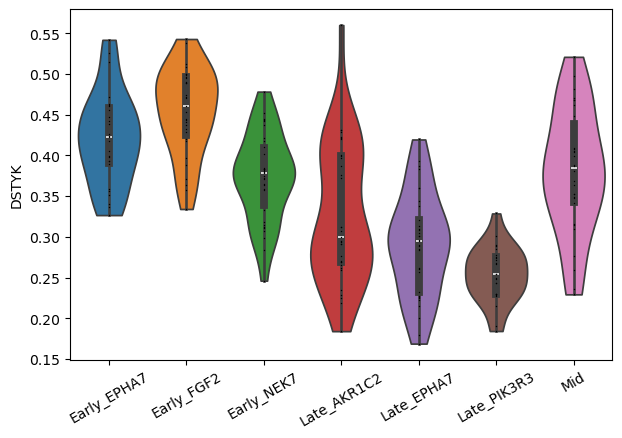

In [16]:
sc.pl.violin(expr, "DSTYK", groupby = "RNA_anno", rotation = 30, jitter = 0 , inner = "box")